In [1]:
import pandas as pd

columns = ["Overall Qual", "Overall Cond", "Gr Liv Area", "Central Air", "Total Bsmt SF", "SalePrice"]
df = pd.read_csv("http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep = "\t", usecols = columns)

In [2]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
df["Central Air"] = df["Central Air"].map({"N": 0, "Y": 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
df = df.dropna(axis = 0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

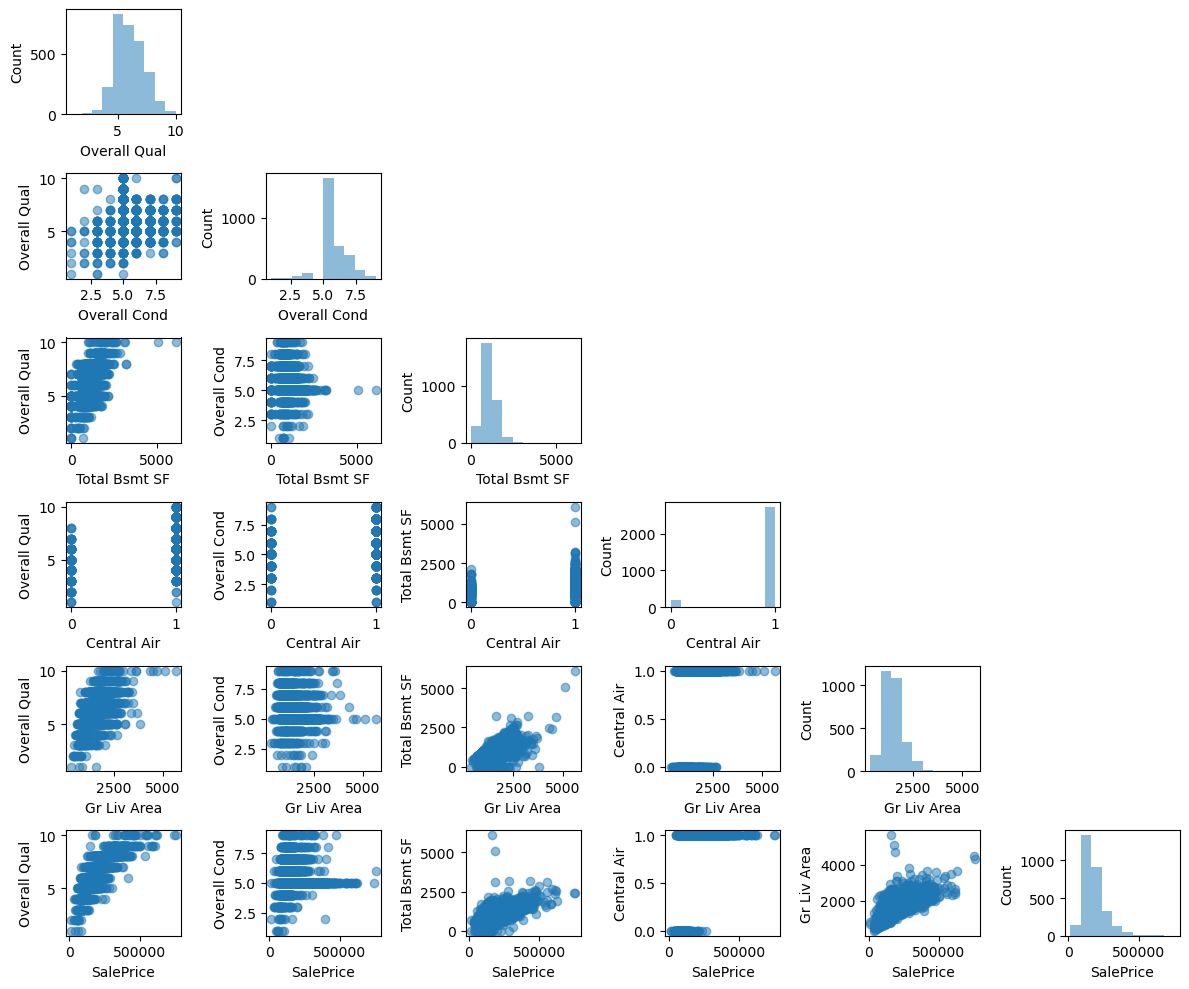

In [6]:
#散布図行列
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize = (12, 10), names = df.columns, alpha = 0.5)
plt.tight_layout()
plt.show()

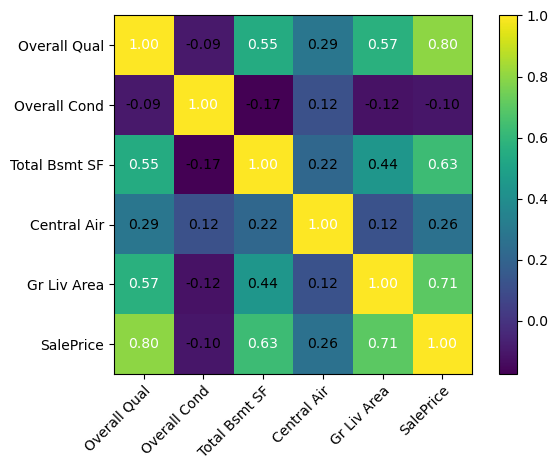

In [7]:
#相関行列
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names = df.columns, column_names = df.columns)
plt.tight_layout()
plt.show()

In [8]:
#線形回帰モデル：ADALINEから閾値関数を削除したもの
class LinearRegressionGD:
    """ADAptive Linear NEutron分類器

    eta:学習率
    n_iter：訓練回数
    random_state：乱数シード
    
    w_：重みベクトル　1次元配列
    b_：バイアスユニット スカラー
    losses：各エポックでのMSE"""
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """訓練データに適合させる
        X：shape = [n_examples, n_features]
        y：shape = [n_examples]
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def activation(self, X):
        return X
    def predict(self, X):
        return self.net_input(X)

In [9]:
from sklearn.preprocessing import StandardScaler

X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta = 0.1)
lr.fit(X_std, y_std)

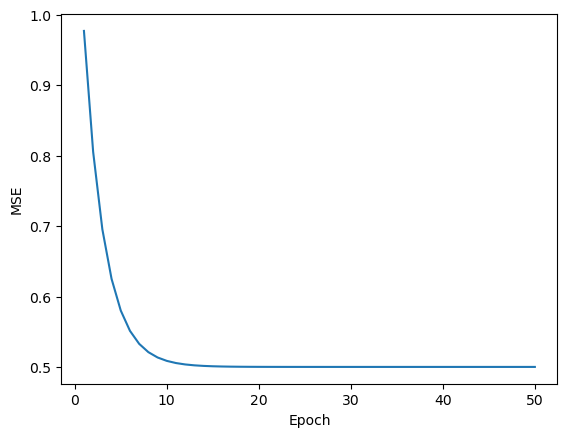

In [10]:
plt.plot(range(1, lr.n_iter + 1), lr.losses_)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

In [11]:
#モデルと訓練データが適合しているかプロット
def lin_regplot(X, y, model):
    plt.scatter(X, y, c = "steelblue", edgecolor = "white", s = 70)
    plt.plot(X, model.predict(X), color = "black", lw = 2)

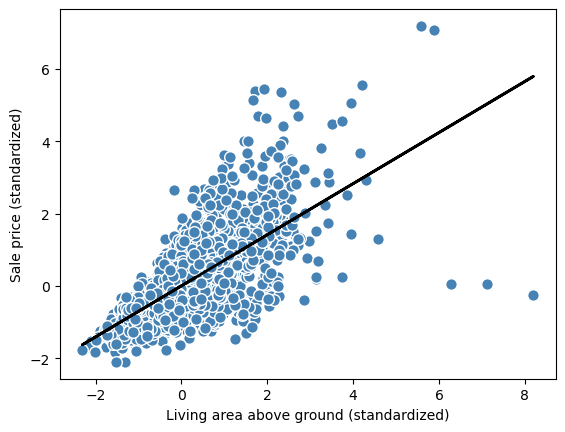

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel("Living area above ground (standardized)")
plt.ylabel("Sale price (standardized)")
plt.show()

In [13]:
#標準化したスケールを元に戻す方法
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f"Sales price: ${target_reverted.flatten()[0]:.2f}")

Sales price: $292507.07


In [14]:
#標準化した場合切片は常に0
print(f"Slope: {lr.w_[0]:.3f}")
print(f"Intercept: {lr.b_:.3f}")

Slope: 0.707
Intercept: -0.000


In [15]:
#scikit-learn の線形回帰
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y) #標準化の必要なし
y_pred = slr.predict(X)
print(f"Slope: {slr.coef_[0]:.3f}")
print(f"Intercept: {slr.intercept_:3f}")

Slope: 111.666
Intercept: 13342.978662


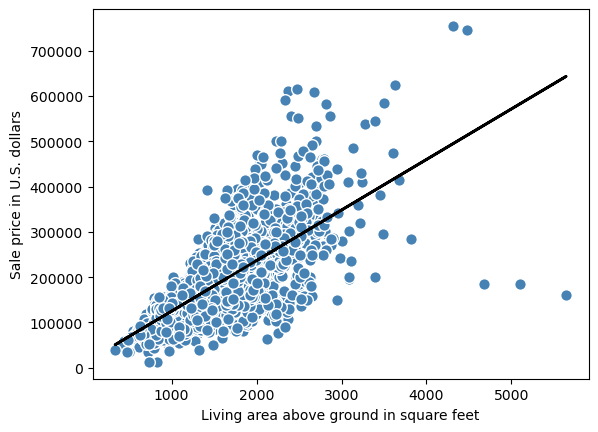

In [16]:
lin_regplot(X, y, slr)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.show()

In [17]:
#RANSACを用いたロバスト回帰
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials = 100, 
                         min_samples = 0.95, #ランダムに選択されるデータの最小数
                         residual_threshold = None, #デフォルト、MAD(中央絶対偏差)で閾値を判断,
                         random_state = 123)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

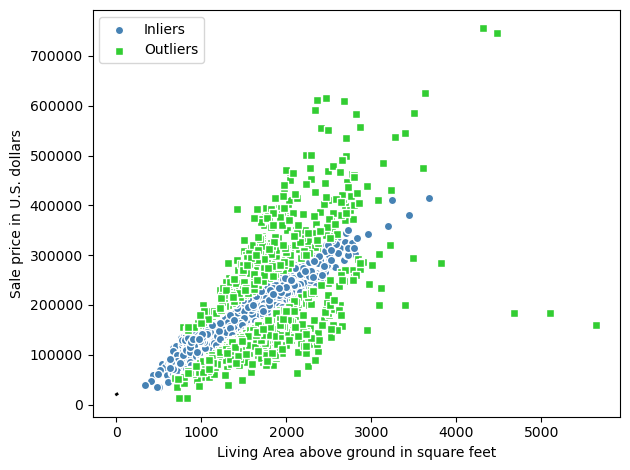

In [18]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c = "steelblue", edgecolor = "white", marker = "o", label = "Inliers") #正常値
plt.scatter(X[outlier_mask], y[outlier_mask], c = "limegreen", edgecolor = "white", marker = "s", label = "Outliers") #外れ値
plt.plot(line_X, line_y_ransac, color = "black", lw = 2)
plt.xlabel("Living Area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

In [20]:
print(f"Slope: {ransac.estimator_.coef_[0]:.3f}")
print(f"Intercept: {ransac.estimator_.intercept_:.3f}")

Slope: 106.348
Intercept: 20190.093


In [22]:
#MADの計算方法
def mean_absolute_devitation(data):
    return np.median(np.abs(data - np.median(data)))
mean_absolute_devitation(y)

37000.0

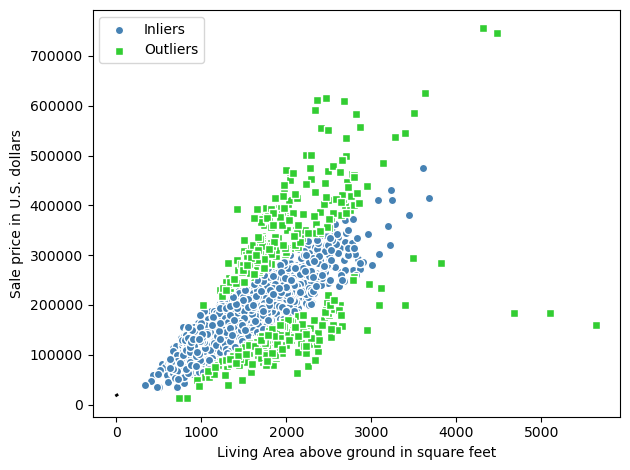

In [25]:
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials = 100, 
                         min_samples = 0.95, #ランダムに選択されるデータの最小数
                         residual_threshold = 65000, #MADより大きい値を設定
                         random_state = 123)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c = "steelblue", edgecolor = "white", marker = "o", label = "Inliers") #正常値
plt.scatter(X[outlier_mask], y[outlier_mask], c = "limegreen", edgecolor = "white", marker = "s", label = "Outliers") #外れ値
plt.plot(line_X, line_y_ransac, color = "black", lw = 2)
plt.xlabel("Living Area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

In [27]:
#全特徴量で訓練
from sklearn.model_selection import train_test_split
target = "SalePrice"
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

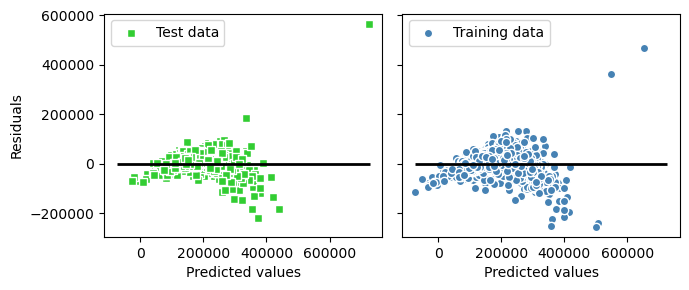

In [30]:
#残渣プロット
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 3), sharey = True)
ax1.scatter(y_test_pred, y_test_pred -y_test,
            c ="limegreen", marker = "s", edgecolor = "white", label = "Test data")
ax2.scatter(y_train_pred, y_train_pred -y_train,
            c ="steelblue", marker = "o", edgecolor = "white", label = "Training data")
ax1.set_ylabel("Residuals")
for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc = "upper left")
    ax.hlines(y = 0, xmin = x_min - 100, xmax = x_max + 100, color = "black", lw = 2)
plt.tight_layout()
plt.show()

In [38]:
#MSE
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train:.2f}")
print(f"MSE test: {mse_test:.2f}")

MSE train: 1497216245.85
MSE test: 1516565821.00


In [39]:
#MAE = MRSE
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")

MAE train: 25983.03
MAE test: 24921.29


In [40]:
#決定係数(スケーリングされた評価値)
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"R^2 train: {train_r2:.3f} test:{test_r2:.3f}")

R^2 train: 0.769 test:0.752


In [41]:
#正則化
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

ridge = Ridge(alpha = 1.0) #L2ペナルティ
lasso = Lasso(alpha = 1.0) #L1ペナルティ
elanet = ElasticNet(alpha = 1.0, l1_ratio = 0.5) #L1+L2

In [46]:
#多項式回帰
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])
lr = LinearRegression()
pr = LinearRegression()
#2次の多項式特徴量のクラスをインスタンス化
quadratic = PolynomialFeatures(degree = 2)
X_quad = quadratic.fit_transform(X)

In [49]:
#単回帰モデル（比較用）
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [50]:
#多項式回帰モデル
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

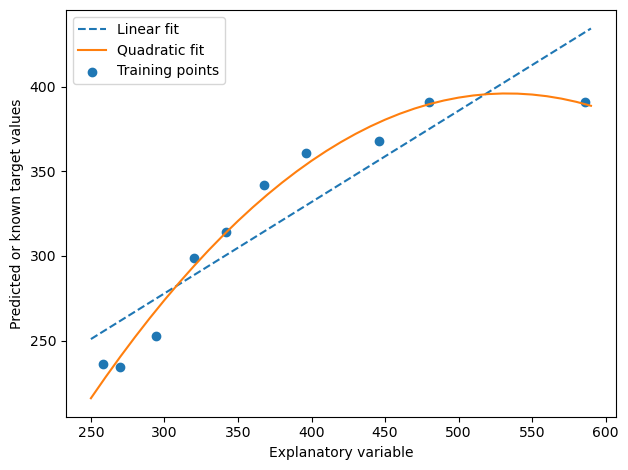

In [51]:
plt.scatter(X, y, label = "Training points")
plt.plot(X_fit, y_lin_fit, label = "Linear fit", linestyle = "--")
plt.plot(X_fit, y_quad_fit, label = "Quadratic fit")
plt.xlabel("Explanatory variable")
plt.ylabel("Predicted or known target values")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

In [55]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f"Training MSE linear: {mse_lin:.3f} quadratic:{mse_quad:.3f}")
r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f"Training R^2 linear: {r2_lin:.3f} quadratic:{r2_quad:.3f}")

Training MSE linear: 569.780 quadratic:61.330
Training R^2 linear: 0.832 quadratic:0.982


In [69]:
#Housingデータセットに適用
X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values
X = X[df["Gr Liv Area"] < 4000] #外れ値を除外
y = y[df["Gr Liv Area"] < 4000]

In [71]:
regr = LinearRegression()
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_fit = np.arange(X.min()-1, X.max()+1, 1)[:, np.newaxis]

regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
r2_lin = r2_score(y, regr.predict(X))

regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
r2_quad = r2_score(y, regr.predict(X_quad))

regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
r2_cubic = r2_score(y, regr.predict(X_cubic))

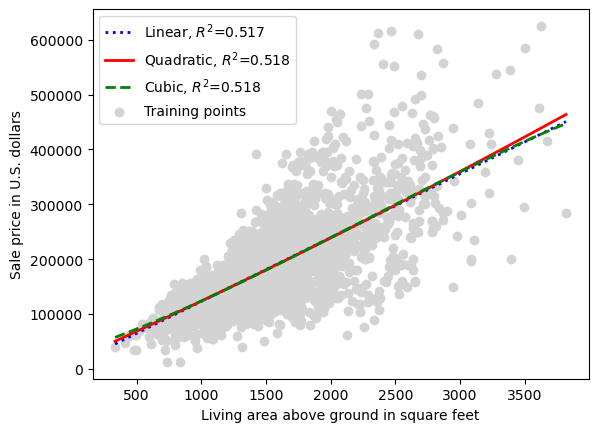

In [72]:
plt.scatter(X, y, label = "Training points", color = "lightgray")
plt.plot(X_fit, y_lin_fit, label = f"Linear, $R^2$={r2_lin:.3f}", color = "blue", lw = 2, linestyle = ":")
plt.plot(X_fit, y_quad_fit, label = f"Quadratic, $R^2$={r2_quad:.3f}", color = "red", lw = 2, linestyle = "-")
plt.plot(X_fit, y_cubic_fit, label = f"Cubic, $R^2$={r2_cubic:.3f}", color = "green", lw = 2, linestyle = "--")
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc = "upper left")
plt.show()

In [73]:
#使用する特徴量を変えてみる
X = df[["Overall Qual"]].values
y = df["SalePrice"].values

In [74]:
regr = LinearRegression()
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_fit = np.arange(X.min()-1, X.max()+1, 1)[:, np.newaxis]

regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
r2_lin = r2_score(y, regr.predict(X))

regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
r2_quad = r2_score(y, regr.predict(X_quad))

regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
r2_cubic = r2_score(y, regr.predict(X_cubic))

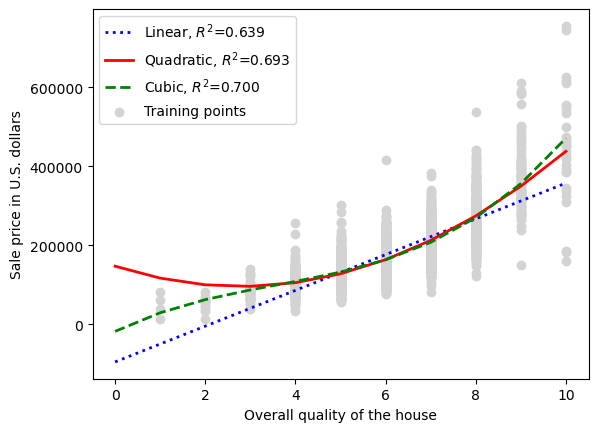

In [76]:
plt.scatter(X, y, label = "Training points", color = "lightgray")
plt.plot(X_fit, y_lin_fit, label = f"Linear, $R^2$={r2_lin:.3f}", color = "blue", lw = 2, linestyle = ":")
plt.plot(X_fit, y_quad_fit, label = f"Quadratic, $R^2$={r2_quad:.3f}", color = "red", lw = 2, linestyle = "-")
plt.plot(X_fit, y_cubic_fit, label = f"Cubic, $R^2$={r2_cubic:.3f}", color = "green", lw = 2, linestyle = "--")
plt.xlabel("Overall quality of the house")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc = "upper left")
plt.show()

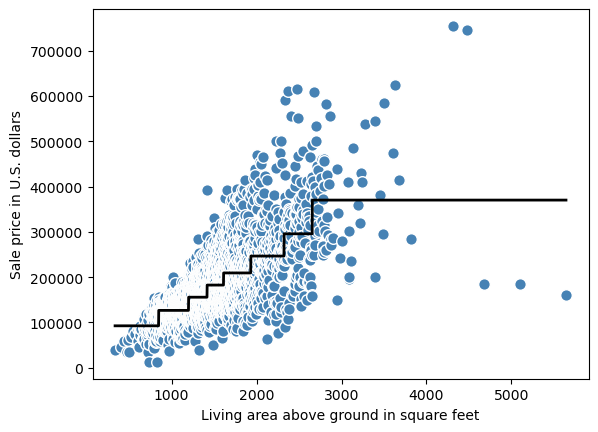

In [87]:
#決定木回帰
from sklearn.tree import DecisionTreeRegressor

X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values
tree = DecisionTreeRegressor(max_depth = 3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.show()

In [88]:
#ランダムフォレスト回帰
from sklearn.ensemble import RandomForestRegressor

target = "SalePrice"
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
forest = RandomForestRegressor(n_estimators = 1000, criterion = "squared_error", random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [89]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {mae_train:.2f} test:{mae_test:.2f}")

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 train: {r2_train:.2f} test:{r2_test:.2f}")

MAE train: 8305.18 test:20821.77
R^2 train: 0.98 test:0.85


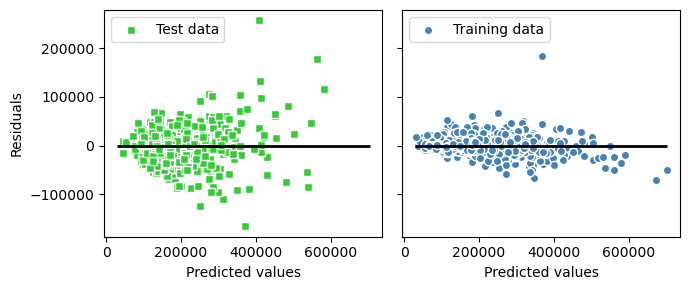

In [90]:
#残渣プロット
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 3), sharey = True)
ax1.scatter(y_test_pred, y_test_pred -y_test,
            c ="limegreen", marker = "s", edgecolor = "white", label = "Test data")
ax2.scatter(y_train_pred, y_train_pred -y_train,
            c ="steelblue", marker = "o", edgecolor = "white", label = "Training data")
ax1.set_ylabel("Residuals")
for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc = "upper left")
    ax.hlines(y = 0, xmin = x_min - 100, xmax = x_max + 100, color = "black", lw = 2)
plt.tight_layout()
plt.show()